In [16]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import plot
import math
import datetime
from datetime import timedelta
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [17]:
filename_cfd_trades = "/Volumes/GoogleDrive/Shared drives/Data/crude/cfd_trades/cl1_trades_27.07.2020-31.07.2020.csv"
filename_futures_quotes = "/Volumes/GoogleDrive/Shared drives/Data/crude/futures/quotes_WT_27.07.2020"
filename_futures_trades = "/Volumes/GoogleDrive/Shared drives/Data/crude/futures/trades_WT_27.07.2020"
filename_cfd_quotes = "/Volumes/GoogleDrive/Shared drives/Data/crude/cfd_prices/quotes_CL_27.07.2020-31.07.2020.csv"

In [18]:
# %% Read the order book data
# Load order books

df_quotes = pd.read_csv(
    filename_futures_quotes + ".csv",
    dtype={
        "Date": str,
        "Time": str,
        "Bid Price": np.float64,
        "Bid Size": np.float64,
        "Ask Price": np.float64,
        "Ask Size": np.float64,
        "Market Flag": str,
        "Quote Condition": str,
    },
)


In [19]:
# Set the index
df_quotes["timestamp"] = df_quotes["Date"] + " " + df_quotes["Time"]
df_quotes["timestamp"] = pd.to_datetime(
    df_quotes["timestamp"], format="%m/%d/%Y %H:%M:%S.%f"
)
df_quotes.set_index("timestamp", inplace=True)
df_quotes.drop(["Date", "Time"], axis=1, inplace=True)
df_quotes.sort_index(inplace=True)

# Drop the useless columns
df_quotes.drop("Market Flag", inplace=True, axis=1)
df_quotes.drop("Quote Condition", inplace=True, axis=1)

# Rename to our standard
df_quotes['Bid0'] = df_quotes['Bid Price']
df_quotes['Bid0Qty'] = df_quotes['Bid Size']
df_quotes['Offer0'] = df_quotes['Ask Price']
df_quotes['Offer0Qty'] = df_quotes['Ask Size']

# Drop unused
df_quotes.drop("Bid Price", inplace=True, axis=1)
df_quotes.drop("Bid Size", inplace=True, axis=1)
df_quotes.drop("Ask Price", inplace=True, axis=1)
df_quotes.drop("Ask Size", inplace=True, axis=1)





In [ ]:
df_quotes['market_mid'] = (df_quotes['Bid0'] + df_quotes['Offer0']) / 2

df_quotes = df_quotes.loc['2020-07-27']
# df_quotes['market_mid'].resample("1T").last().plot()

# df_quotes.to_parquet(filename + ".parq", compression="snappy")


df_quotes = df_quotes.loc[~df_quotes.index.duplicated(keep='last')]

In [24]:
def genr_mid(df):
    df["mid"] = (df["Bid0"] + df["Offer0"]) / 2
    return df["mid"]

In [25]:
df_quotes["mid"] = genr_mid(df_quotes)

In [26]:
df_quotes.head()

,Symbol,Bid0,Bid0Qty,Offer0,Offer0Qty,mid
timestamp,,,,,,
2020-07-26 23:00:00.324,WTU20,41.18,3.0,NaN,NaN,NaN
2020-07-26 23:00:00.324,WTU20,41.18,3.0,41.33,3.0,41.255
2020-07-26 23:00:00.409,WTU20,41.18,3.0,41.37,3.0,41.275
2020-07-26 23:00:00.409,WTU20,41.18,3.0,41.37,6.0,41.275
2020-07-26 23:00:00.409,WTU20,41.18,3.0,41.37,3.0,41.275


In [5]:
# # we have guessed the basis to be 4.5 cents
# basis = -0.0445

# #%%Chart the returns on the strategy
# trace1 = go.Scatter(x=result.index, y=result['market_mid_quotes'], name ='market_mid_quotes')
# trace2 = go.Scatter(x=result.index, y=(result['market_mid_CFD'] + basis), name ='market_mid_CFD')

# data = [trace1,trace2]
# fig = go.Figure(data=data)
# plot(fig, filename = 'market_mid_quotes.html')

In [6]:

def ofi(quotes,level):
    """Returns Order Flow Imbalance for given levels of the orderbook"""
    qdf = quotes.copy()
    bid_price_label = 'Bid' + str(level)
    offer_price_label = 'Offer' + str(level)
    bid_qty_label = 'Bid' +str(level) + 'Qty'
    offer_qty_label = 'Offer' + str(level)+'Qty'

    qdf['prev_bidprice'] = qdf[bid_price_label].shift()
    qdf['prev_bidsize'] = qdf[bid_qty_label].shift()
    qdf['prev_askprice'] = qdf[offer_price_label].shift()
    qdf['prev_asksize'] = qdf[offer_qty_label].shift()

    # Fix any missing/invalid data
    qdf.replace([np.inf, np.NINF], np.nan, inplace=True)
    qdf.fillna(method="ffill", inplace=True)
    qdf.fillna(method="bfill", inplace=True)
    
    bid_geq = qdf[bid_price_label] >= qdf['prev_bidprice']
    bid_leq = qdf[bid_price_label] <= qdf['prev_bidprice']
    ask_geq = qdf[offer_price_label] >= qdf['prev_askprice']
    ask_leq = qdf[offer_price_label] <= qdf['prev_askprice']
    
    qdf['ofi'] = np.zeros(len(qdf))
    qdf['ofi'].loc[bid_geq] += qdf[bid_qty_label].loc[bid_geq]
    qdf['ofi'].loc[bid_leq] -= qdf['prev_bidsize'].loc[bid_leq]
    qdf['ofi'].loc[ask_geq] += qdf['prev_asksize'].loc[ask_geq]
    qdf['ofi'].loc[ask_leq] -= qdf[offer_qty_label].loc[ask_leq]    
    return qdf['ofi']




In [7]:
########################
# OFI using top x levels 
########################

df_quotes = df_quotes.resample("100ms").last().ffill()
df_quotes = df_quotes

df_quotes["Offer0Qty"] = df_quotes["Offer0Qty"].astype('float')
df_quotes["Offer0"] = df_quotes["Offer0"].astype('float')
df_quotes["Bid0"] = df_quotes["Bid0"].astype('float')
df_quotes["Bid0Qty"] = df_quotes["Bid0Qty"].astype('float')



In [14]:
# OFI with level 0 as we don't have L2 for oil yet 
# 100 period MA works well 

df_quotes['ofi'] = ofi(df_quotes,0) 
df_quotes['ofi_signal'] = np.where(df_quotes['ofi'].rolling(100).mean() > 0, 1, -1)
df_quotes['mid'] = ((df_quotes['Bid0'] + df_quotes['Offer0']) / 2.0)
df_quotes['mid_change'] = ((df_quotes['Bid0'] + df_quotes['Offer0']) / 2.0).pct_change()

# shift the signal
df_quotes['ofi_signal'] = df_quotes['ofi_signal'].shift(1)
df_quotes['ofi_pnl'] = (df_quotes['ofi_signal'] * df_quotes['mid_change'])

print("Cumulative PnL " + str(df_quotes['ofi_pnl'].cumsum().iloc[-1]))

Cumulative PnL 0.11610894596356713


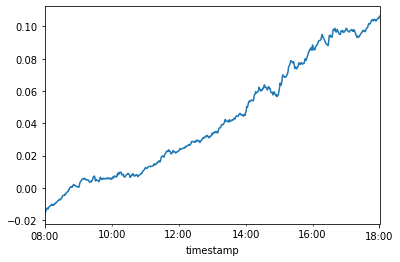

In [15]:
df_quotes['ofi_pnl'].cumsum().resample("1t").last().between_time("08:00", "18:00").plot()

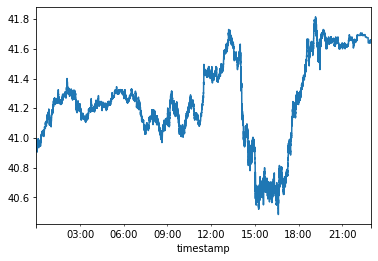

In [16]:
df_quotes['mid'].plot()

## Load the WTI trades

In [44]:
#%% Read the data
# Load trades
df_trades = pd.read_csv(
    filename_futures_trades+ ".csv",
    dtype={
        "Date": str,
        "Time": str,
        "Price": np.float64,
        "Volume": np.float64,
        "Market Flag": str,
    },
)

# Set the index
df_trades["timestamp"] = df_trades["Date"] + " " + df_trades["Time"]
df_trades["timestamp"] = pd.to_datetime(
    df_trades["timestamp"], format="%m/%d/%Y %H:%M:%S.%f"
)
df_trades.set_index("timestamp", inplace=True)
df_trades.drop(["Date", "Time"], axis=1, inplace=True)
df_trades.sort_index(inplace=True)

#drop unused columns
df_trades.drop("Market Flag", inplace=True, axis=1)
#df_trades.to_parquet(filename_trades + ".parq", compression="snappy")




## Load the CFD price and CFD trades done by Think

In [17]:
# CFD trades done by Think
df_cfd_trades = pd.read_csv(filename_cfd_trades, parse_dates=True, index_col="DateTime")
df_cfd_trades.drop(["transact_time", "market_type", "counterparty", "instrument"], axis=1, inplace=True)


In [18]:

#%%The CfD file
df_cfd = pd.read_csv(filename_cfd_quotes,parse_dates=True)

df_cfd['t'] = pd.to_datetime(df_cfd['t'],errors='coerce')
df_cfd['t']  = df_cfd['t'].dt.tz_localize(None)
df_cfd['t']  = df_cfd['t']+ pd.DateOffset(hours=1)

df_cfd.set_index("t",inplace=True)


df_cfd['market_mid'] = (df_cfd['Bid0'] + df_cfd['Offer0']) / 2

df_cfd = df_cfd.loc['2020-07-27']

df_cfd = df_cfd.loc[~df_cfd.index.duplicated(keep='last')]


#%%
#add suffix to all the column names of dataframe  - you need to do this otherwise it can have duplicate names
df_cfd = df_cfd.add_suffix('_CFD')
#same for the other one
df_quotes = df_quotes.add_suffix('_quotes')
# df_cfd_trades = df_cfd_trades.add_suffix('_cfd_trades')

result = pd.concat([df_cfd, df_quotes], axis=1, sort=True)
result = result.fillna(method='ffill')

In [20]:
df_cfd_trades.head(50)

,trade_price,trade_quantity,side
DateTime,,,
2020-07-26 22:00:01.326,41.38,50.0,OFFER
2020-07-26 22:00:01.327,41.38,10.0,OFFER
2020-07-26 22:00:01.327,41.38,10.0,OFFER
2020-07-26 22:00:01.327,41.38,10.0,OFFER
2020-07-26 22:00:01.328,41.38,20.0,OFFER
2020-07-26 22:00:01.330,41.38,50.0,OFFER
2020-07-26 22:00:01.331,41.38,20.0,OFFER
2020-07-26 22:00:01.331,41.38,20.0,OFFER
2020-07-26 22:00:01.332,41.38,20.0,OFFER
